In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import time
from scipy import stats

## Đọc dữ liệu

In [10]:
df = pd.read_csv('D:\jena_climate_2009_2016.csv')

print(f"Kích thước gốc: {df.shape}")
print(df.head())

Kích thước gốc: (420551, 15)
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0   

## Chuẩn hóa cột thời gian

In [11]:
print("\nChuẩn hóa cột Date Time...")
df['Date Time'] = pd.to_datetime(df['Date Time'],
                                 format='%d.%m.%Y %H:%M:%S',
                                 dayfirst=True)



Chuẩn hóa cột Date Time...


In [12]:
# Kiểm tra có dòng nào parse lỗi không
if df['Date Time'].isnull().sum() > 0:
    print("Có lỗi parse thời gian! Dùng infer...")
    df['Date Time'] = pd.to_datetime(df['Date Time'], infer_datetime_format=True)
df = df.set_index('Date Time')
df = df.sort_index()  # đảm bảo thứ tự thời gian tăng dần

In [13]:
print(f"Thời gian bắt đầu: {df.index.min()}")
print(f"Thời gian kết thúc : {df.index.max()}")
print(f"Tổng số quan trắc : {len(df)}")
print(f"Tần suất          : {df.index.to_series().diff().value_counts().index[0]}")

Thời gian bắt đầu: 2009-01-01 00:10:00
Thời gian kết thúc : 2017-01-01 00:00:00
Tổng số quan trắc : 420551
Tần suất          : 0 days 00:10:00


# Kiểm tra missing values & duplicate timestamps-

In [14]:
print("\nKiểm tra missing values...")
print(df.isnull().sum())


Kiểm tra missing values...
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


In [15]:
print("\nKiểm tra duplicate timestamps...")
duplicate_times = df.index.duplicated().sum()
print(f"Số timestamp trùng lặp: {duplicate_times}")
if duplicate_times > 0:
    df = df[~df.index.duplicated(keep='first')]
    print(f"Đã loại bỏ → còn {len(df)} dòng")


Kiểm tra duplicate timestamps...
Số timestamp trùng lặp: 327
Đã loại bỏ → còn 420224 dòng


# Thêm các đặc trưng thời gian

In [16]:
print("\nThêm các đặc trưng thời gian mùa vụ...")
df['hour']   = df.index.hour
df['day']    = df.index.day
df['month']  = df.index.month
df['year']   = df.index.year
df['day_of_week'] = df.index.dayofweek      # 0 = Monday
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week


Thêm các đặc trưng thời gian mùa vụ...


In [ ]:
# Sin/cos encoding để mô hình hiểu tính tuần hoàn
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin']  = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['day_cos']  = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


# Kiểm tra outliers

In [ ]:
z_scores = np.abs(stats.zscore(df['T (degC)']))
outlier_threshold = 5  # rất nghiêm ngặt
outliers = df[z_scores > outlier_threshold]

In [ ]:
print(f"\nSố điểm ngoại lai nhiệt độ (|Z| > {outlier_threshold}): {len(outliers)}")
if len(outliers) > 0:
    print("Ví dụ outliers:")
    print(outliers['T (degC)'].head(10))


Số điểm ngoại lai nhiệt độ (|Z| > 5): 0


# Lựa chọn features & chuẩn bị cho mô hình

In [ ]:
# Các cột sẽ dùng để dự báo
feature_columns = [
    'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
    'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
    'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)',
    # Thêm các đặc trưng thời gian
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos'
]

In [ ]:
target_column = 'T (degC)'

In [ ]:
print(f"\nSố features cuối cùng: {len(feature_columns)}")
print("Features:", feature_columns)


Số features cuối cùng: 20
Features: ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']


In [ ]:
# Tạo dataframe sạch
data_final = df[feature_columns].copy()

In [ ]:
# Điền missing nếu có (forward fill + backward fill)
data_final = data_final.ffill().bfill()

In [ ]:
print(f"\nDữ liệu sẵn sàng cho mô hình!")
print(f"Kích thước: {data_final.shape}")
print(f"Thời gian: từ {data_final.index.min()} đến {data_final.index.max()}")


Dữ liệu sẵn sàng cho mô hình!
Kích thước: (420224, 20)
Thời gian: từ 2009-01-01 00:10:00 đến 2017-01-01 00:00:00


In [ ]:
# Lưu
data_final.to_csv("jena_climate_processed.csv")
print("\nĐã lưu file đã xử lý: jena_climate_processed.csv")


Đã lưu file đã xử lý: jena_climate_processed.csv


# Trực quan hóa dữ liệu

In [ ]:
plt.figure(figsize=(16, 10))

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

Text(0, 0.5, '°C')

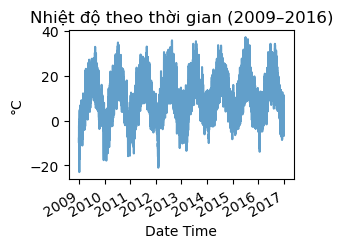

In [ ]:
plt.subplot(2, 2, 1)
df['T (degC)'].plot(alpha=0.7)
plt.title('Nhiệt độ theo thời gian (2009–2016)')
plt.ylabel('°C')

Text(0, 0.5, '%')

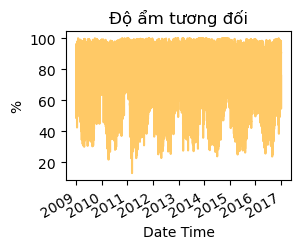

In [ ]:
plt.subplot(2, 2, 2)
df['rh (%)'].plot(color='orange', alpha=0.6)
plt.title('Độ ẩm tương đối')
plt.ylabel('%')

Text(0, 0.5, 'mbar')

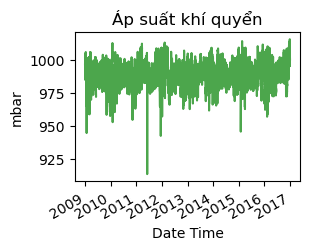

In [ ]:
plt.subplot(2, 2, 3)
df['p (mbar)'].plot(color='green', alpha=0.7)
plt.title('Áp suất khí quyển')
plt.ylabel('mbar')

Text(0, 0.5, 'm/s')

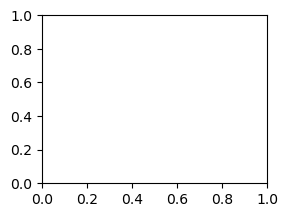

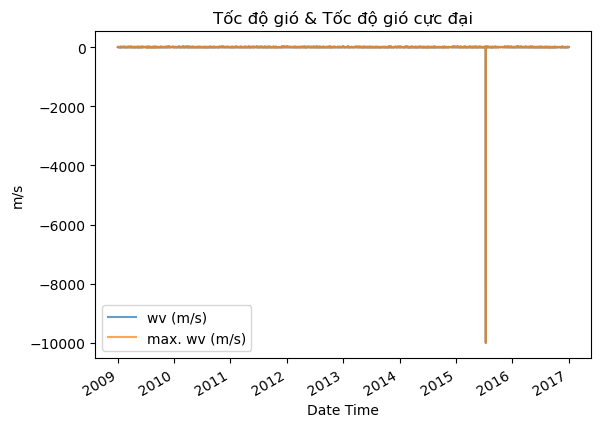

In [ ]:
plt.subplot(2, 2, 4)
df[['wv (m/s)', 'max. wv (m/s)']].plot(alpha=0.7)
plt.title('Tốc độ gió & Tốc độ gió cực đại')
plt.ylabel('m/s')

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# Phân tích chu kỳ mùa & ngày

In [ ]:
plt.figure(figsize=(14, 8))

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

Text(0, 0.5, '°C')

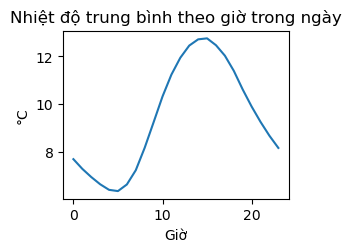

In [ ]:
plt.subplot(2, 2, 1)
df.groupby('hour')['T (degC)'].mean().plot()
plt.title('Nhiệt độ trung bình theo giờ trong ngày')
plt.xlabel('Giờ'); plt.ylabel('°C')

Text(0.5, 0, 'Tháng')

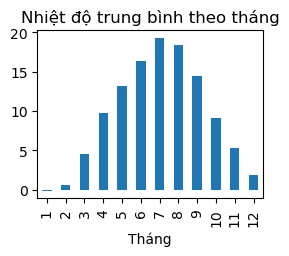

In [ ]:
plt.subplot(2, 2, 2)
df.groupby('month')['T (degC)'].mean().plot(kind='bar')
plt.title('Nhiệt độ trung bình theo tháng')
plt.xlabel('Tháng')

([<matplotlib.axis.XTick at 0x1743a9a7650>,
 [Text(0, 0, 'T2'),
  Text(1, 0, 'T3'),
  Text(2, 0, 'T4'),
  Text(3, 0, 'T5'),
  Text(4, 0, 'T6'),
  Text(5, 0, 'T7'),
  Text(6, 0, 'CN')])

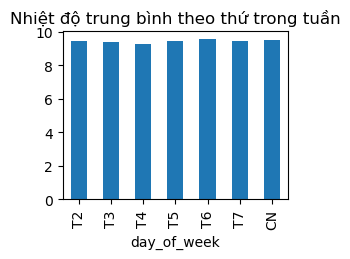

In [ ]:
plt.subplot(2, 2, 3)
df.groupby('day_of_week')['T (degC)'].mean().plot(kind='bar')
plt.title('Nhiệt độ trung bình theo thứ trong tuần')
plt.xticks(ticks=range(7), labels=['T2','T3','T4','T5','T6','T7','CN'])

Text(0, 0.5, '°C')

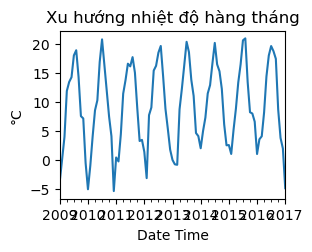

In [ ]:
plt.subplot(2, 2, 4)
df['T (degC)'].resample('M').mean().plot()
plt.title('Xu hướng nhiệt độ hàng tháng')
plt.ylabel('°C')

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# Tương quan giữa các biến

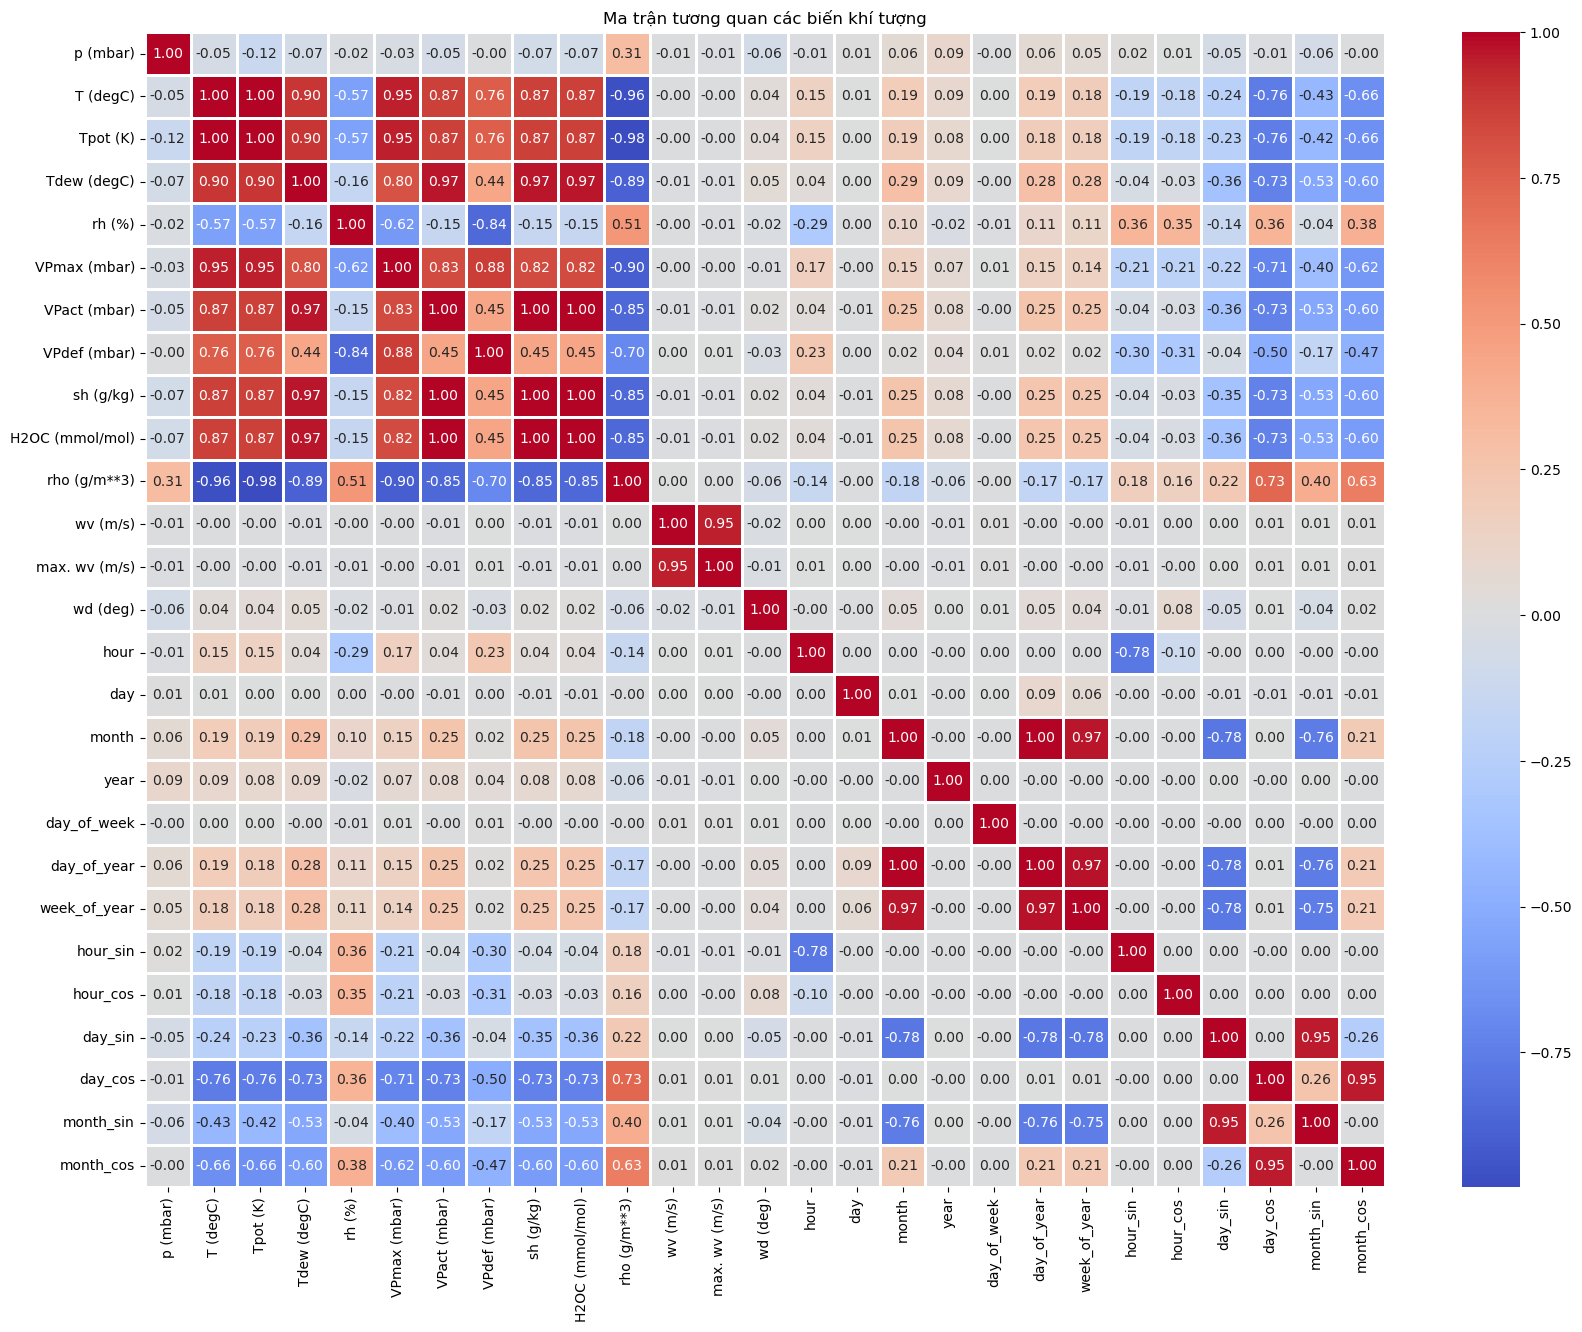

In [ ]:
plt.figure(figsize=(20, 15))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.9)
plt.title('Ma trận tương quan các biến khí tượng')
plt.show()

# Phân tích dự báo

In [ ]:
X = data_final.drop(columns=[target_column])
y = data_final[target_column]

print("Đã tách dữ liệu thành X (features) và y (target).")
print(f"Kích thước của X: {X.shape}")
print(f"Kích thước của y: {y.shape}")

Đã tách dữ liệu thành X (features) và y (target).
Kích thước của X: (420224, 19)
Kích thước của y: (420224,)


In [ ]:
# Khởi tạo các danh sách để lưu trữ các chỉ số
rmse_scores = []
mse_scores = []
r2_scores = []
training_times = []
prediction_times = []

print("Đã khởi tạo danh sách lưu trữ điểm số.")

Đã khởi tạo danh sách lưu trữ điểm số.


In [ ]:
n_bootstrap_iterations = 10

for i in range(n_bootstrap_iterations):
    print(f"\nĐang chạy Bootstrap Iteration {i+1}/{n_bootstrap_iterations}...")

    # a. Tạo một mẫu bootstrap
    bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
    X_bootstrap = X.iloc[bootstrap_indices]
    y_bootstrap = y.iloc[bootstrap_indices]

    # b. Chia dữ liệu X và y đã resampling thành tập huấn luyện và tập kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X_bootstrap, y_bootstrap, test_size=0.2, random_state=i)

    # c. Khởi tạo một mô hình LinearRegression
    model = LinearRegression()

    # d. Huấn luyện mô hình và ghi lại thời gian huấn luyện
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    # e. Thực hiện dự đoán và ghi lại thời gian dự đoán
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

    # f. Tính toán các chỉ số đánh giá
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # g. Thêm các chỉ số đã tính toán vào các danh sách tương ứng
    rmse_scores.append(rmse)
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"  RMSE: {rmse:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")
    print(f"  Thời gian huấn luyện: {training_time:.4f} giây, Thời gian dự đoán: {prediction_time:.4f} giây")

print("Đã hoàn thành tất cả các vòng lặp bootstrap.")


Đang chạy Bootstrap Iteration 1/10...
  RMSE: 0.0092, MSE: 0.0001, R2: 1.0000
  Thời gian huấn luyện: 0.1986 giây, Thời gian dự đoán: 0.0035 giây

Đang chạy Bootstrap Iteration 2/10...
  RMSE: 0.0092, MSE: 0.0001, R2: 1.0000
  Thời gian huấn luyện: 0.1862 giây, Thời gian dự đoán: 0.0060 giây

Đang chạy Bootstrap Iteration 3/10...
  RMSE: 0.0091, MSE: 0.0001, R2: 1.0000
  Thời gian huấn luyện: 0.2496 giây, Thời gian dự đoán: 0.0071 giây

Đang chạy Bootstrap Iteration 4/10...
  RMSE: 0.0092, MSE: 0.0001, R2: 1.0000
  Thời gian huấn luyện: 0.1991 giây, Thời gian dự đoán: 0.0035 giây

Đang chạy Bootstrap Iteration 5/10...
  RMSE: 0.0090, MSE: 0.0001, R2: 1.0000
  Thời gian huấn luyện: 0.2167 giây, Thời gian dự đoán: 0.0045 giây

Đang chạy Bootstrap Iteration 6/10...
  RMSE: 0.0091, MSE: 0.0001, R2: 1.0000
  Thời gian huấn luyện: 0.2044 giây, Thời gian dự đoán: 0.0053 giây

Đang chạy Bootstrap Iteration 7/10...
  RMSE: 0.0092, MSE: 0.0001, R2: 1.0000
  Thời gian huấn luyện: 0.2363 giây, Th

In [ ]:
print("Tóm tắt kết quả Bootstrap")
print(f"RMSE Trung bình: {np.mean(rmse_scores):.4f} (Độ lệch chuẩn: {np.std(rmse_scores):.4f})")
print(f"MSE Trung bình: {np.mean(mse_scores):.6f} (Độ lệch chuẩn: {np.std(mse_scores):.6f})")
print(f"R2 Trung bình: {np.mean(r2_scores):.4f} (Độ lệch chuẩn: {np.std(r2_scores):.4f})")
print(f"Thời gian huấn luyện Trung bình: {np.mean(training_times):.4f} giây (Độ lệch chuẩn: {np.std(training_times):.4f} giây)")
print(f"Thời gian dự đoán Trung bình: {np.mean(prediction_times):.4f} giây (Độ lệch chuẩn: {np.std(prediction_times):.4f} giây)")

Tóm tắt kết quả Bootstrap
RMSE Trung bình: 0.0096 (Độ lệch chuẩn: 0.0015)
MSE Trung bình: 0.000095 (Độ lệch chuẩn: 0.000034)
R2 Trung bình: 1.0000 (Độ lệch chuẩn: 0.0000)
Thời gian huấn luyện Trung bình: 0.2577 giây (Độ lệch chuẩn: 0.0305 giây)
Thời gian dự đoán Trung bình: 0.0050 giây (Độ lệch chuẩn: 0.0013 giây)


In [ ]:
print("--- Tóm tắt kết quả Bootstrap ---")
print(f"RMSE Trung bình: {np.mean(rmse_scores):.4f} (Độ lệch chuẩn: {np.std(rmse_scores):.4f})")
print(f"MSE Trung bình: {np.mean(mse_scores):.6f} (Độ lệch chuẩn: {np.std(mse_scores):.6f})")
print(f"R2 Trung bình: {np.mean(r2_scores):.4f} (Độ lệch chuẩn: {np.std(r2_scores):.4f})")
print(f"Thời gian huấn luyện Trung bình: {np.mean(training_times):.4f} giây (Độ lệch chuẩn: {np.std(training_times):.4f} giây)")
print(f"Thời gian dự đoán Trung bình: {np.mean(prediction_times):.4f} giây (Độ lệch chuẩn: {np.std(prediction_times):.4f} giây)")

--- Tóm tắt kết quả Bootstrap ---
RMSE Trung bình: 0.0096 (Độ lệch chuẩn: 0.0015)
MSE Trung bình: 0.000095 (Độ lệch chuẩn: 0.000034)
R2 Trung bình: 1.0000 (Độ lệch chuẩn: 0.0000)
Thời gian huấn luyện Trung bình: 0.2577 giây (Độ lệch chuẩn: 0.0305 giây)
Thời gian dự đoán Trung bình: 0.0050 giây (Độ lệch chuẩn: 0.0013 giây)
